# Add word-level tokens and fine-tune models

Do not adapt the tokenizers here, but rather include, based on two
strategies (TF / TF-idF), complete words whose representation should be
learned by the model atop.

NOTE (21/06/22): Tokenizers add tokens based on `add_tokens` method. Changed
 to `add_special_tokens` since by the docs the latter does not split these
 added tokens.

In [2]:
import os
import pickle
import shutil
import numpy

from tqdm import tqdm
from tools.dim_reduction import Umap
from tools.clustering import Hdbscan
from tools.linguistics import tf_idf

from sklearn import model_selection
from sklearn import linear_model
from sklearn import pipeline
from sklearn import preprocessing

from torch.nn import MSELoss
from dataset_definition.videomem import VideoMem
from dataset_definition.memento10k import Memento10K
from data_preprocess.tokenizers import CustomBertTokenizer,BytePairEncodingTokenizer
from data_preprocess.datasets import SentencesDataset
from metrics.regression_metrics import RegressionMetrics
from neural_models.transformers import CustomBert, CustomGPT2, CustomTextualCLIP
from workflow.kfolds import KFoldExperiment

Building dataset VideoMem from /media/ricardokleinlein/HDD1/DATA/VIDEOMEM


## Global variables

In [ ]:
DATASET_PATH = "/home/ricardokleinlein/MemoryExtensionVocab/videomem.csv"
LABELS_FIELD = 'short-term_memorability'
CONTROL_METRIC = 'loss'
BATCH_SIZE = 8
PATIENCE = 5

videomem = VideoMem(DATASET_PATH)
# memento = Memento10K(DATASET_PATH)

# def append_dot(s: str) -> str:
#     """Append a final dot to a sentence if it doesn't have it already"""
#     if s[-1] in [',', ' ']:
#         return s[:-1] + '.'
#     return s + '.'
#
# def remove_inner_dots(s: str) -> str:
#     """Replace dots within the sentence by commas."""
#     return s.replace('.', '')
#
#
# memento = Memento10K(DATASET_PATH)
# cols = [f'description_{i}' for i in range(5)]
# texts = memento.df[cols].applymap(remove_inner_dots)
# texts = texts.applymap(append_dot)
# texts = texts.apply(''.join, axis=1).apply(lambda s: s.lower()).iloc[:8500]
# X = texts
# scores = memento.df[LABELS_FIELD][:8500]

## Baselines

Do not change anything in either tokenizers or the feature extractors, and
only train a linear regressor fed on those precomputed embeddings.

In [1]:
from transformers import BertTokenizer, BertModel
toks = BertTokenizer.from_pretrained('bert-base-uncased')
model_base = BertModel.from_pretrained('bert-base-uncased')

# from transformers import GPT2Tokenizer, GPT2Model
# toks = GPT2Tokenizer.from_pretrained('gpt2')
# model_base = GPT2Model.from_pretrained('gpt2')
#
# from transformers import CLIPTokenizer, CLIPTextModel
# toks = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
# model_base = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

def compute_bert(sentence):
    inputs = toks(sentence, return_tensors='pt')
    output = model_base(**inputs).pooler_output.squeeze().detach().cpu().numpy()
    return output

def compute_gpt2(sentence):
    inputs = toks(sentence, return_tensors='pt')
    output = model_base(**inputs).last_hidden_state[:, -1].squeeze().detach().cpu().numpy()
    return output

def compute_clip(sentence):
    inputs = toks(sentence, return_tensors='pt')
    output = model_base(**inputs).pooler_output.squeeze().detach().cpu().numpy()
    return output

def compute(sentences, fn):
    for s, sentence in tqdm(enumerate(list(sentences)), total=len(sentences)):
        x = fn(sentence)
        numpy.save(os.path.join('./baseline-tmp', str(s)), x)

def load(fromdir):
    X = [numpy.load('./baseline-tmp/' + str(s) + '.npy') for s, _ in enumerate(list(sentences))]
    shutil.rmtree(fromdir)
    return numpy.array(X)

def experiment(X: numpy.ndarray , labels: numpy.ndarray, kfolds: int = 5):
    """

    Args:
        X: (N, D) data embeddings.
        labels: (N,) ground truth labels.
        kfolds: Number of K-Folds.

    Returns:
        Dict: Folds' Spearman & Overall Score
    """
    k_folds = model_selection.KFold(n_splits=kfolds, shuffle=True,
                                    random_state=1234)
    log = {f'fold_{k+1}': dict() for k in range(kfolds)}
    foldgen = k_folds.split(X, labels)
    for k, fold in enumerate(foldgen):
        train, test = fold
        X_train, X_test = X[train], X[test]
        y_train, y_test = labels[train], labels[test]

        lr = pipeline.make_pipeline(preprocessing.StandardScaler(
            with_mean=True, with_std=True),
            linear_model.LinearRegression()
        )

        lr.fit(X_train, y_train)
        preds = lr.predict(X_test)
        log[f'fold_{k+1}'] = metrics.compute(y_test, preds)
    return log

metrics = RegressionMetrics()
sentences = videomem.get_description()
scores = videomem.get_scores()
os.makedirs('./baseline-tmp', exist_ok=True)
compute(sentences, compute_clip)
X = load('./baseline-tmp')
experiment(X, videomem.df[LABELS_FIELD])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Retrain

Retrain only the DL part of the pipeline.

In [ ]:
model = CustomBert(num_classes=1, finetune=False, multisentence=False)
# model = CustomGPT2(num_classes=1, finetune=False, multisentence=False)
# model = CustomTextualCLIP(num_classes=1, finetune=False, multisentence=False)

tokenizer = CustomBertTokenizer('bert-base-uncased').tokenizer
# tokenizer = BytePairEncodingTokenizer('gpt2')
# tokenizer = BytePairEncodingTokenizer('openai/clip-vit-base-patch32')

metrics = RegressionMetrics()
experiment_adapt = KFoldExperiment(data_reader=SentencesDataset,
                                   metrics=metrics,
                                   monitor_metric=CONTROL_METRIC,
                                   patience=PATIENCE,
                                   tokenizer=tokenizer)
experiment_adapt.run(X=sentences,
                     target=scores,
                     model=model,
                     loss_fn=MSELoss(),
                     batch_size=BATCH_SIZE)

## Words by TF

### A) Take up to the most frequent 500 words

Text(0.5, 1.0, 'Term frequency')

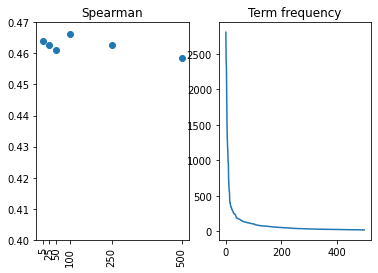

In [50]:
nb_terms = [5, 25, 50, 100, 250, 500]
results = {k: None for k in nb_terms}

for nb in nb_terms:
    tokenizer_wrap = CustomBertTokenizer('bert-base-uncased')
    added_vocab = tokenizer_wrap.add_tokens_tf(videomem.df['description'],
                                               top_n=nb)

    model = CustomBert(num_classes=1, finetune=False, multisentence=False)
    model.resize_embeddings_layer(len(tokenizer_wrap))

    regression_metrics = RegressionMetrics()
    experiment = KFoldExperiment(data_reader=SentencesDataset,
                             metrics=regression_metrics,
                             monitor_metric=CONTROL_METRIC,
                             patience=PATIENCE,
                             tokenizer=tokenizer_wrap.tokenizer)

    results_logging = experiment.run(X=videomem.df['description'],
                                 target=videomem.df[LABELS_FIELD],
                                 model=model,
                                 loss_fn=MSELoss(),
                                 batch_size=BATCH_SIZE)



## Words by TF-iDF
### A) 1-3-5 top words / cluster

In [2]:
# Compute embeddings from pretrained model
import os
import shutil
import numpy
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
default_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
default_model = BertModel.from_pretrained('bert-base-uncased')

sentences = videomem.get_description()

def compute_embedding(sentence):
    inputs = default_tokenizer(sentence, return_tensors='pt', padding=True)
    output = default_model(**inputs).pooler_output.detach().cpu().numpy()[0]
    return output

os.makedirs('./tmp', exist_ok=True)
for s, sentence in tqdm(enumerate(list(sentences))):
    x = compute_embedding(sentence)
    numpy.save(os.path.join('./tmp', str(s)), x)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
8000it [03:20, 39.90it/s]


In [3]:
X = [numpy.load('./tmp/' + str(s) + '.npy') for s, _ in enumerate(list(sentences))]
shutil.rmtree('./tmp')
X = numpy.array(X)
X.shape

(8000, 768)

In [4]:
# Clustering
from tools.dim_reduction import Umap
from tools.clustering import Hdbscan
from tools.linguistics import tf_idf
import pickle

nb_words = [1, 3, 5]
results = {k: None for k in nb_words}
X_u = Umap(5, nneighs=25)(X)
clusterer = Hdbscan(8)
clusterer.fit(X_u)
docs = clusterer.build_as_documents(sentences)

for nb in nb_words:
    top_words = tf_idf(docs, top_k=nb)
    with open(f'tf_idf-{nb}-terms.pkl', 'wb') as f:
        pickle.dump(top_words, f)

    unique_terms = list(set([w for top in top_words.values() for w in top]))

    tokenizer_wrap = CustomBertTokenizer('bert-base-uncased')
    tokenizer_wrap.tokenizer.add_tokens(unique_terms)

    model = CustomBert(num_classes=1, finetune=False, multisentence=False)
    model.resize_embeddings_layer(len(tokenizer_wrap))
    #
    regression_metrics = RegressionMetrics()
    experiment = KFoldExperiment(data_reader=SentencesDataset,
                             metrics=regression_metrics,
                             monitor_metric=CONTROL_METRIC,
                             patience=PATIENCE,
                             tokenizer=tokenizer_wrap.tokenizer)

    results_logging = experiment.run(X=videomem.df['description'],
                                 target=videomem.df[LABELS_FIELD],
                                 model=model,
                                 loss_fn=MSELoss(),
                                 batch_size=BATCH_SIZE)

    results[nb] = results_logging

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[NEW FOLD: 1/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.95it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:25<00:00,  6.25it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:25<00:00,  6.36it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:25<00:00,  6.30it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:25<00:00,  6.19it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:26<00:00,  6.15it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:25<00:00,  6.27it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:25<00:00,  6.38it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


[NEW FOLD: 2/5]
Computing initial model performance...


100%|██████████| 160/160 [00:25<00:00,  6.36it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:25<00:00,  6.29it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:25<00:00,  6.30it/s]


Patience left: 4 epochs.
Epoch 3 / 500


100%|██████████| 160/160 [00:25<00:00,  6.27it/s]


Saving new model...
Epoch 4 / 500


100%|██████████| 160/160 [00:25<00:00,  6.25it/s]


Patience left: 4 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:25<00:00,  6.27it/s]


Patience left: 3 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:25<00:00,  6.19it/s]


Patience left: 2 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.48it/s]


Patience left: 1 epochs.
Epoch 8 / 500


100%|██████████| 160/160 [00:24<00:00,  6.55it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.79it/s]


[NEW FOLD: 3/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.75it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.57it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.55it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.52it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.64it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.56it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.82it/s]


[NEW FOLD: 4/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.69it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.57it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.51it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.55it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.57it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.57it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.56it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.83it/s]


[NEW FOLD: 5/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.82it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.61it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.61it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.55it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:23<00:00,  6.72it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.88it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[NEW FOLD: 1/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.85it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.47it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.51it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.46it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.63it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.57it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.49it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.50it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


[NEW FOLD: 2/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.76it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.51it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.51it/s]


Patience left: 4 epochs.
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.49it/s]


Saving new model...
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.49it/s]


Patience left: 4 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.50it/s]


Patience left: 3 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.52it/s]


Patience left: 2 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Patience left: 1 epochs.
Epoch 8 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.77it/s]


[NEW FOLD: 3/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.76it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.52it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.50it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.56it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.52it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.55it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.78it/s]


[NEW FOLD: 4/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.74it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.49it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.52it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.55it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.50it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.50it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.77it/s]


[NEW FOLD: 5/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.76it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.52it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.49it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.51it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.58it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.46it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.51it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.81it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[NEW FOLD: 1/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.92it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.47it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.62it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.50it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.59it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.78it/s]


[NEW FOLD: 2/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.79it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.52it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Patience left: 4 epochs.
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.52it/s]


Saving new model...
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.56it/s]


Patience left: 4 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.61it/s]


Patience left: 3 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.55it/s]


Patience left: 2 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Patience left: 1 epochs.
Epoch 8 / 500


100%|██████████| 160/160 [00:24<00:00,  6.56it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.84it/s]


[NEW FOLD: 3/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.76it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.60it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.61it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.59it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.60it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.80it/s]


[NEW FOLD: 4/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.74it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.56it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.62it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.55it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.65it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.57it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.83it/s]


[NEW FOLD: 5/5]
Computing initial model performance...


100%|██████████| 160/160 [00:23<00:00,  6.75it/s]


Epoch 1 / 500


100%|██████████| 160/160 [00:24<00:00,  6.53it/s]


Saving new model...
Epoch 2 / 500


100%|██████████| 160/160 [00:24<00:00,  6.52it/s]


Saving new model...
Epoch 3 / 500


100%|██████████| 160/160 [00:24<00:00,  6.59it/s]


Patience left: 4 epochs.
Epoch 4 / 500


100%|██████████| 160/160 [00:24<00:00,  6.61it/s]


Patience left: 3 epochs.
Epoch 5 / 500


100%|██████████| 160/160 [00:24<00:00,  6.62it/s]


Patience left: 2 epochs.
Epoch 6 / 500


100%|██████████| 160/160 [00:24<00:00,  6.57it/s]


Patience left: 1 epochs.
Epoch 7 / 500


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]


Patience left: 0 epochs.
[Early-Stopping]: Leaving training loop...


100%|██████████| 200/200 [00:29<00:00,  6.81it/s]


In [5]:
with open('tf-idf.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
tfidf = pickle.load(open('tf-idf.pkl', 'rb'))
tfidf

## Hypernyms


In [38]:
sysn = wordnet.synsets("jumping")
print(sysn)
print(sysn[0].hypernyms())


[Synset('jumping.n.01'), Synset('jump.n.06'), Synset('jump.v.01'), Synset('startle.v.02'), Synset('jump.v.03'), Synset('jump.v.04'), Synset('leap_out.v.01'), Synset('jump.v.06'), Synset('rise.v.11'), Synset('jump.v.08'), Synset('derail.v.02'), Synset('chute.v.01'), Synset('jump.v.11'), Synset('jumpstart.v.01'), Synset('jump.v.13'), Synset('leap.v.02'), Synset('alternate.v.01')]
[Synset('track_and_field.n.01')]
